In [26]:
import pandas as pd

# Define the data types for each column
column_types = {
    'departamento': 'category',
    'municipio': 'category',
    'sexo': 'category',
    'año_registrado': 'category', 
    'edad': 'int64',  
    'periodo': 'category',
    'etnia': 'category',
    'escolaridad': 'category',
    'ocupacion': 'category',
    'causa': 'category',
    'asistencia': 'category',
    'lugar': 'category'
}

# Read the CSV file and explicitly define the data types
defunciones = pd.read_csv('defunciones_clean.csv', dtype=column_types)

# See which columns have missing values
defunciones.isnull().sum()

# Drop rows with missing values
defunciones = defunciones.dropna()

defunciones.head()


,departamento,municipio,sexo,año_registrado,edad,periodo,etnia,escolaridad,ocupacion,causa,asistencia,lugar
70905,14.0,1415,1.0,2013,91,3.0,1.0,1.0,61,K259,5.0,6.0
70906,14.0,1411,1.0,2013,81,3.0,1.0,1.0,61,K259,5.0,6.0
70907,16.0,1601,1.0,2013,68,3.0,1.0,9.0,92,K259,5.0,6.0
70908,1.0,0116,1.0,2013,80,3.0,9.0,1.0,61,K259,5.0,6.0
70909,12.0,1219,1.0,2013,75,3.0,4.0,1.0,92,K259,5.0,6.0


In [27]:
# Simplify the ICD-10 codes (target variable), by grouping them into broader categories
import json 

with open('codes.json', 'r') as f:
    codes = json.load(f)
    
# Each entry has a code, a description, and a level, level 1 is not too broad and not too specific.
code_map = {entry['code']: entry['code'] for entry in codes if entry['level'] == 0}

# print the code_map
print(code_map)

# We can use this function to simplify the codes of the target variable!
def simplify_icd10(code):
    if pd.isna(code):
        return 'Unknown'
    
    code = code.split('.')[0]  # Remove any decimal points and subsequent characters
    code_prefix = code[:3]  # Get the first three characters of the code
    
    for code_range in code_map:
        if '-' not in code_range:
            if code_range[:3] == code_prefix:
                return code_map[code_range]
        else:
            start, end = code_range.split('-')
            start_prefix = start[:3]
            end_prefix = end[:3]
            
            # for example, if the code is 'A01' and the range is 'A00-A09', then 'A01' is in the range
            if start_prefix <= code_prefix <= end_prefix:
                return code_map[code_range]
    
    # If the code doesn't match any range or single code, return 'Other'
    return 'Other'


defunciones['causa_simplificada'] = defunciones['causa'].apply(simplify_icd10)

# defunciones.head()

{'A00-B99': 'A00-B99', 'C00-D49': 'C00-D49', 'D50-D89': 'D50-D89', 'E00-E89': 'E00-E89', 'F01-F99': 'F01-F99', 'G00-G99': 'G00-G99', 'H00-H59': 'H00-H59', 'H60-H95': 'H60-H95', 'I00-I99': 'I00-I99', 'J00-J99': 'J00-J99', 'K00-K95': 'K00-K95', 'L00-L99': 'L00-L99', 'M00-M99': 'M00-M99', 'N00-N99': 'N00-N99', 'O00-O9A': 'O00-O9A', 'P00-P96': 'P00-P96', 'Q00-Q99': 'Q00-Q99', 'R00-R99': 'R00-R99', 'S00-T88': 'S00-T88', 'V01-Y99': 'V01-Y99', 'Z00-Z99': 'Z00-Z99'}


Numero de causas antes de simplificar: 3007
Numero de causas despues de simplificar: 20


/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_93874/1751690866.py:22: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  simple_causes['ocupacion'] = simple_causes['ocupacion'].replace(['NEOG', 'IGNORADO'], mode)


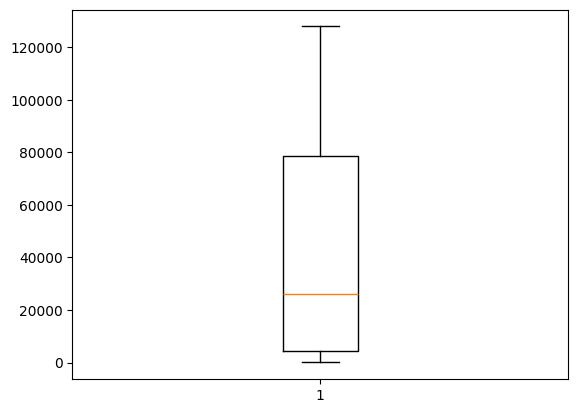

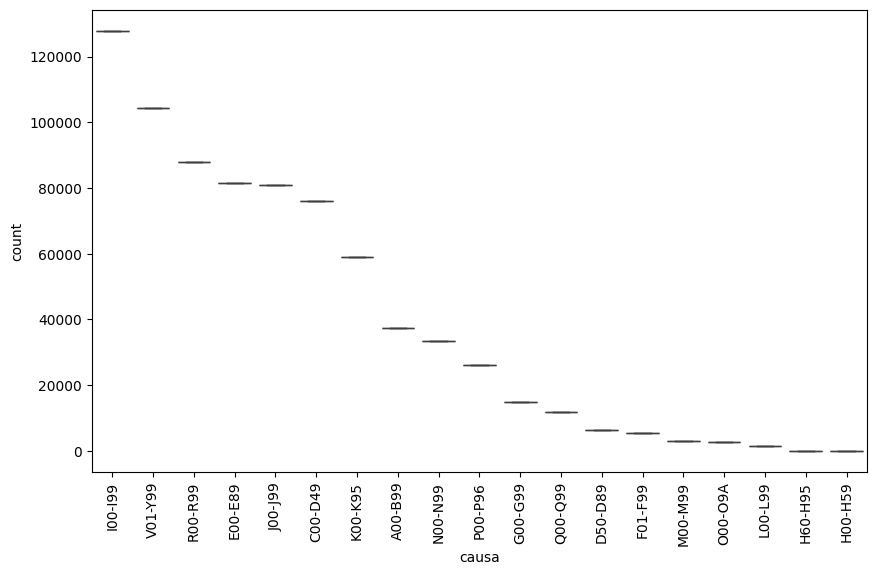

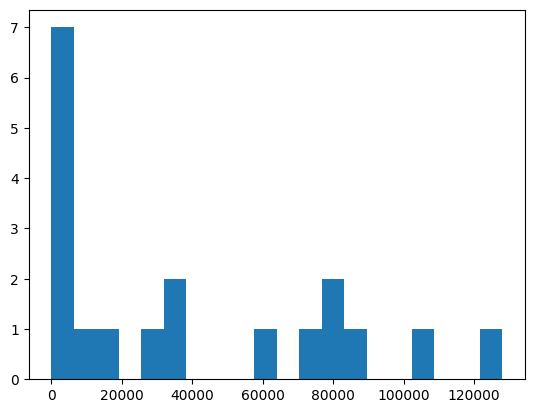

age_group
65+      343771
51-65    132465
0-18     104161
19-35     89109
36-50     86891
Name: count, dtype: int64


In [35]:
from sklearn.calibration import LabelEncoder
import seaborn as sns

print('Numero de causas antes de simplificar:', defunciones['causa'].nunique())
print('Numero de causas despues de simplificar:', defunciones['causa_simplificada'].nunique())

simple_causes = defunciones.copy()
# Drop the original 'causa' column, and remove any "Other" causes
simple_causes = simple_causes.drop(columns=['causa'])
simple_causes = simple_causes[simple_causes['causa_simplificada'] != 'Other']

# see how much data we have left
simple_causes.shape
simple_causes.head()

# rename causa_simplificada to causa
simple_causes = simple_causes.rename(columns={'causa_simplificada': 'causa'})


#remove values in 'ocupacion' that are 'NEOG' or 'IGNORADO', with the mode
mode = simple_causes['ocupacion'].mode()[0]
simple_causes['ocupacion'] = simple_causes['ocupacion'].replace(['NEOG', 'IGNORADO'], mode)

# simple_causes = simple_causes[simple_causes['ocupacion'] != 'NEOG']
# simple_causes = simple_causes[simple_causes['ocupacion'] != 'IGNORADO']

# Check for outliers  in causa count (rare diseases or causes)
causa_counts = simple_causes['causa'].value_counts()

# boxplot of the counts
import matplotlib.pyplot as plt
plt.boxplot(causa_counts)
plt.show()

causa_counts_df = simple_causes['causa'].value_counts().reset_index()
causa_counts_df.columns = ['causa', 'count']

# Create a boxplot for each cause
plt.figure(figsize=(10, 6))
sns.boxplot(x='causa', y='count', data=causa_counts_df)
plt.xticks(rotation=90)
plt.show()


# see  the distribution of the classes
plt.hist(causa_counts, bins=20)
plt.show()


# remove the outliers
causa_counts = causa_counts[causa_counts < 10000]

simple_causes['age_group'] = pd.cut(simple_causes['edad'], bins=[0, 18, 35, 50, 65, float('inf')], 
                           labels=['0-18', '19-35', '36-50', '51-65', '65+'])


print(simple_causes['age_group'].value_counts())






/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix:


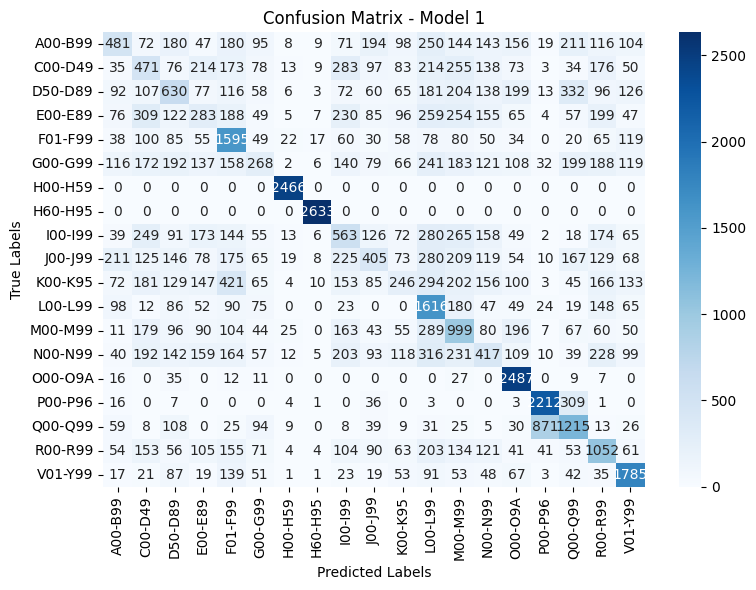

Accuracy: 0.4482602801626751



In [37]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, pair_confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier

# Load the dataset
data = simple_causes.copy()
data = data.sample(frac=0.1, random_state=42)

# Separate features and target
X = data.drop('causa', axis=1)
X = X.drop('edad', axis=1) # drop the age column, we will use the age_group column
y = data['causa']

# Apply Random Oversampling
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X, y)

# Use all available features
selected_features = X.columns.tolist()


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create the preprocessing pipeline
# numeric_features = ['edad']
categorical_features = [feat for feat in selected_features if feat != 'edad' ]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# # Create the pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('model',  LogisticRegression(max_iter=1000, C=1, penalty='l2', solver='saga'))])

# # Fit the model
# pipeline.fit(X_train, y_train)

# # Make predictions
# y_pred = pipeline.predict(X_test)

# # Calculate and print the confusion matrix and accuracy
# print("Confusion Matrix:")
# cm = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.title(f"Confusion Matrix - Model 1")
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.tight_layout()
# plt.show()
    
# plt.show()
# print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model',  DecisionTreeClassifier(random_state=42))])

# Fit the model
pipeline2.fit(X_train, y_train)

# Make predictions
y_pred = pipeline2.predict(X_test)

# Calculate and print the confusion matrix and accuracy
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix - Model 2")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# parameters = [{'model__C': 1, 'model__l1_ratio': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga'},
#               {'model__C': 1.0, 'model__penalty': 'l2'},
#               {'model__C': 10.0, 'model__penalty': 'l2'}]

# for param in parameters:
#     # Set the parameters
#     pipeline.set_params(**param)
    
  

# # Define the hyperparameter grid for GridSearchCV
# param_grid = {
#     'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'model__penalty': ['l1', 'l2', 'elasticnet'],
#     'model__C': [0.1, 1, 10],
#     'model__l1_ratio': [0.1, 0.5, 0.9]
# }

# # Perform grid search cross-validation
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Get the best model and accuracy
# best_model = grid_search.best_estimator_
# best_score = grid_search.best_score_
# best_params = grid_search.best_params_

# # Make predictions on the test set using the best model
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# cm = confusion_matrix(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)

# print("Best Hyperparameters:", best_params)
# print("Best Accuracy:", best_score)
# print("Confusion Matrix:")
# print(cm)
# print("Test Accuracy:", accuracy)

Best Hyperparameters: {'model__C': 1, 'model__l1_ratio': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga'}